In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd

pd.set_option('display.max_columns', 50)

In [203]:
# 2-digit code indicating the Technology of Transmission used to offer broadband service. 
def tech_code_translator(x):
    # ADSL, Cable, Fiber, Fixed Wireless, Satellite, Other
    if x in ['10', '11', '12', '20', '30']:
        return 'ADSL'
    if x in ['40', '41', '42', '43']:
        return 'Cable'
    if x == '50':
        return 'Fiber'
    if x == '60':
        return 'Satellite'
    if x == '70':
        return 'Fixed Wireless'
    return 'Other'
#     if x == '10':
#         return 'Asymetrical xDSL'
#     if x == '11':
#         return 'ADSL2'
#     if x == '12':
#         return 'VDSL' 
#     if x == '20':
#         return 'Symetrical xDSL'
#     if x == '30':
#         return 'Other Copper Wireline'
#     if x == '40':
#         return 'Cable Modem'
#     if x == '41':
#         return 'Cable Modem-DOCSIS1,1.1,2.0'
#     if x == '42':
#         return 'Cable Modem-DOCSIS 3.0'
#     if x == '43': 
#         return 'Cable Modem-DOCSIS 3.1'
#     if x == '50':
#         return 'Optical Carrier/Fiber to the End User'
#     if x == '60':
#         return 'Satellite'
#     if x == '70':
#         return 'Terrestrial Fixed Wireless'
#     if x == '90': 
#         return 'Electric Power Line'
#     if x == '0':
#         return 'Other'
#     return 'NOT VALID'

In [204]:
fcc_data_filepath = '../data/Fixed_Broadband_Deployment_Data__Jun__2019_Status_V1.csv'

converters = {'tract': lambda x: str(x), 
              'block': lambda x: str(x),
              'Technology Code': lambda x: tech_code_translator(x)
             }

data_file = pd.read_csv(fcc_data_filepath, converters = converters, encoding = "ISO-8859-1")
data_file.rename(columns={'Census Block FIPS Code':'FIPS Code'}, inplace=True)
data_file.head()

,Logical Record Number,Provider ID,FRN,Provider Name,DBA Name,Holding Company Name,Holding Company Number,Holding Company Final,State,FIPS Code,Technology Code,Consumer,Max Advertised Downstream Speed (mbps),Max Advertised Upstream Speed (mbps),Business,Max CIR Downstream Speed (mbps),Max CIR Upstream Speed (mbps),county_code,tract,block,boro
0,19376907,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001000001,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,0001,bronx
1,19376908,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001000002,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,0002,bronx
2,19376909,50820,4963088,"ViaSat, Inc.",Viasat Inc,"ViaSat, Inc.",290111,"ViaSat, Inc.",NY,360050001001000,Satellite,1,35.0,3.0,1,0.0,0.0,36005,000100,1000,bronx
3,59544342,52979,1568880,GCI Communication Corp.,GCI Communication Corp.,GCI Holdings LLC,130534,GCI Holdings LLC,NY,360050001001000,Satellite,0,0.0,0.0,1,0.0,0.0,36005,000100,1000,bronx
4,59881129,53153,12369286,"HNS License Sub, LLC",HughesNet,"Hughes Network Systems, LLC",130627,"Hughes Network Systems, LLC",NY,360050001001000,Satellite,1,25.0,3.0,1,0.0,0.0,36005,000100,1000,bronx


In [205]:
cos_25mps = list(data_file[(data_file["Max Advertised Downstream Speed (mbps)"] >= 25)]['Provider Name'].unique())
cos_25mps

data_file[data_file['Provider Name'].isin(cos_25mps)]['Provider Name'].unique()

array(['ViaSat, Inc.', 'HNS License Sub, LLC',
       'RCN Telecom Services of New York, LP',
       'Charter Communications, Inc.', 'Verizon New York Inc.',
       'CSC Holdings LLC', 'XCHANGE TELECOM CORP.', 'Brooklyn Fiber',
       'Taconic Telephone Corp.', 'Berkshire Telephone Corp.',
       'Nuvisions', 'Honest Networks, Inc.', 'Starry, Inc',
       'Sky Fiber Internet', 'Atlantech Online, Inc.',
       'Chautauqua & Erie Telephone Corporation', 'TELECOM PROFESSIONALS'],
      dtype=object)

In [206]:
total_cb = len(data_file['FIPS Code'].unique())

cb_25Mbps = len(data_file[(data_file["Max Advertised Downstream Speed (mbps)"] >= 25)]['FIPS Code'].unique())
cb_1Gbps = len(data_file[(data_file["Max Advertised Downstream Speed (mbps)"] >= 1000)]['FIPS Code'].unique())

print("There are {} census blocks".format(total_cb))

print("Blocks with access to at least 25 Mbps: {0:.2%}".format(cb_25Mbps/total_cb))
print("Blocks with access to at least 01 Gbps: {0:.2%}".format(cb_1Gbps/total_cb))

There are 39148 census blocks
Blocks with access to at least 25 Mbps: 100.00%
Blocks with access to at least 01 Gbps: 30.17%


In [207]:
data_file[data_file['FIPS Code'] == 360610135001006]

tech_code_filter = [ 'Fiber']
nonZeroService = data_file[True 
#                    & (data_file['FIPS Code'] == 360610135001006) 
                     & (data_file['Technology Code'].isin(tech_code_filter)) 
                     & (data_file['Max Advertised Downstream Speed (mbps)'] > 25)
                  ][['Provider Name', 'Technology Code', 'FIPS Code', 'boro']].drop_duplicates()[['FIPS Code', 'boro']]

blocksByProviders = nonZeroService.groupby(['FIPS Code', 'boro'], as_index=False).size().reset_index().rename(columns={0:'unique_providers'})

In [208]:
print("Distinct Providers for: ", tech_code_filter)
print("{0:.2%} of districts have any options".format(len(blocksByProviders)/total_cb))
for i in range(1, blocksByProviders['unique_providers'].max()+1):
    count = len(blocksByProviders[blocksByProviders['unique_providers'] == i])
    res = "{0:.4%}".format(count/total_cb)
    print("{} dist. provider(s):".format(i), res)

Distinct Providers for:  ['Fiber']
76.67% of districts have any options
1 dist. provider(s): 73.9629%
2 dist. provider(s): 2.6055%
3 dist. provider(s): 0.0945%
4 dist. provider(s): 0.0026%


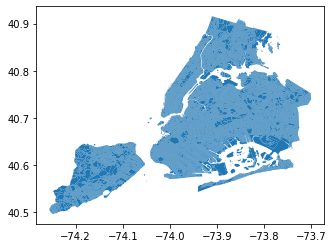

In [209]:
nyc_gpd = gpd.read_file("../data/2010_Census_Blocks/geo_export_7829e0ad-0816-4dbe-b8a1-d10343209019.shp")
nyc_gpd.plot()

In [210]:
boro_to_code = {'manhattan': '36061', 'brooklyn': '36047', 'bronx': '36005', 'queens': '36081', 'staten island':  '36085'}

def getFIPSCode(row):
    return int(boro_to_code[row['boro_name'].lower()] + row['ct2010'] + row['cb2010'])       

nyc_gpd['FIPS Code'] = nyc_gpd.apply(getFIPSCode, axis=1)
nyc_gpd = nyc_gpd.merge(blocksByProviders[['FIPS Code','unique_providers']], on='FIPS Code')
nyc_gpd['unique_providers'].fillna(0, inplace=True)
nyc_gpd.head()

,bctcb2010,boro_code,boro_name,cb2010,ct2010,shape_area,shape_leng,geometry,FIPS Code,unique_providers
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,POLYGON ((-74.07920577013245 40.64343078374567...,360850009001000,1
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,POLYGON ((-74.07061992438017 40.61085506705416...,360850020011000,1
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,POLYGON ((-74.07524403910642 40.62600632452712...,360850027001000,1
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,POLYGON ((-74.08708799689826 40.61116883123925...,360850040001000,1
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,POLYGON ((-74.07643744511992 40.60100160655585...,360850064001000,1


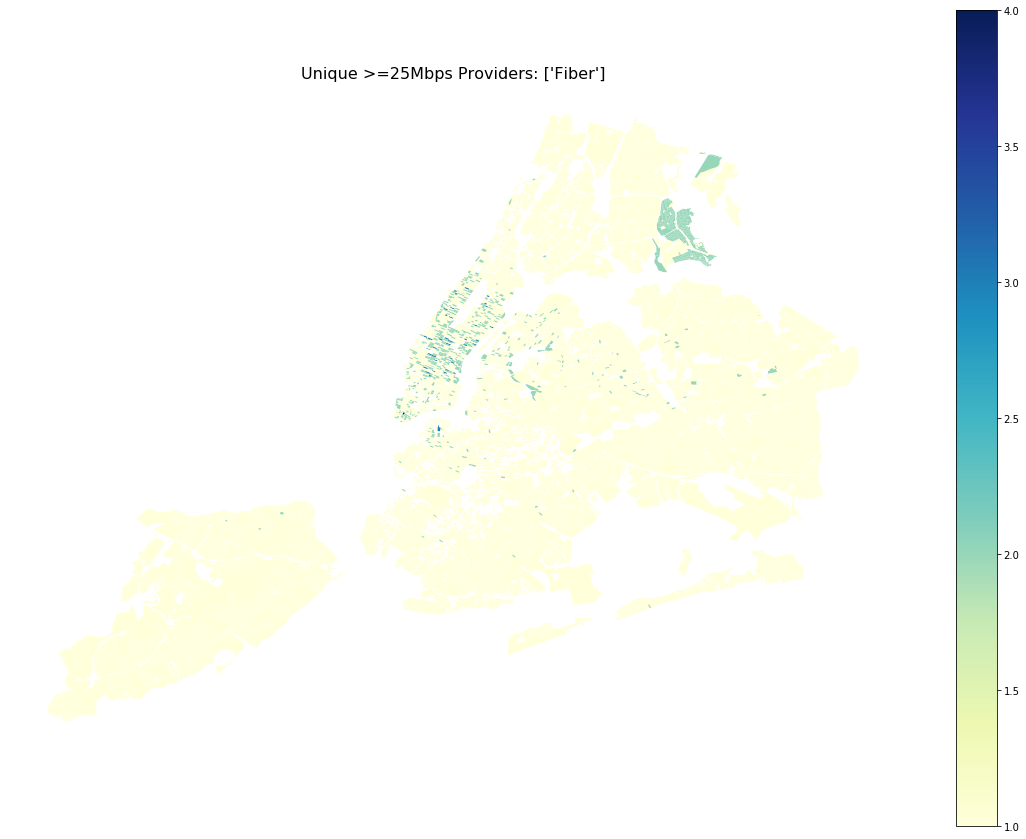

In [211]:
# fig, ax = plt.subplots(1, figsize=(10, 10))
ax = nyc_gpd.plot(figsize=(20,15), column='unique_providers', cmap='YlGnBu', legend=True, edgecolor="none")
ax.set_title('Unique >=25Mbps Providers: '+str(tech_code_filter), fontdict={'fontsize': 16, 'fontweight' : '3'})
ax.axis('off')
# ax.plot()
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plt.show()

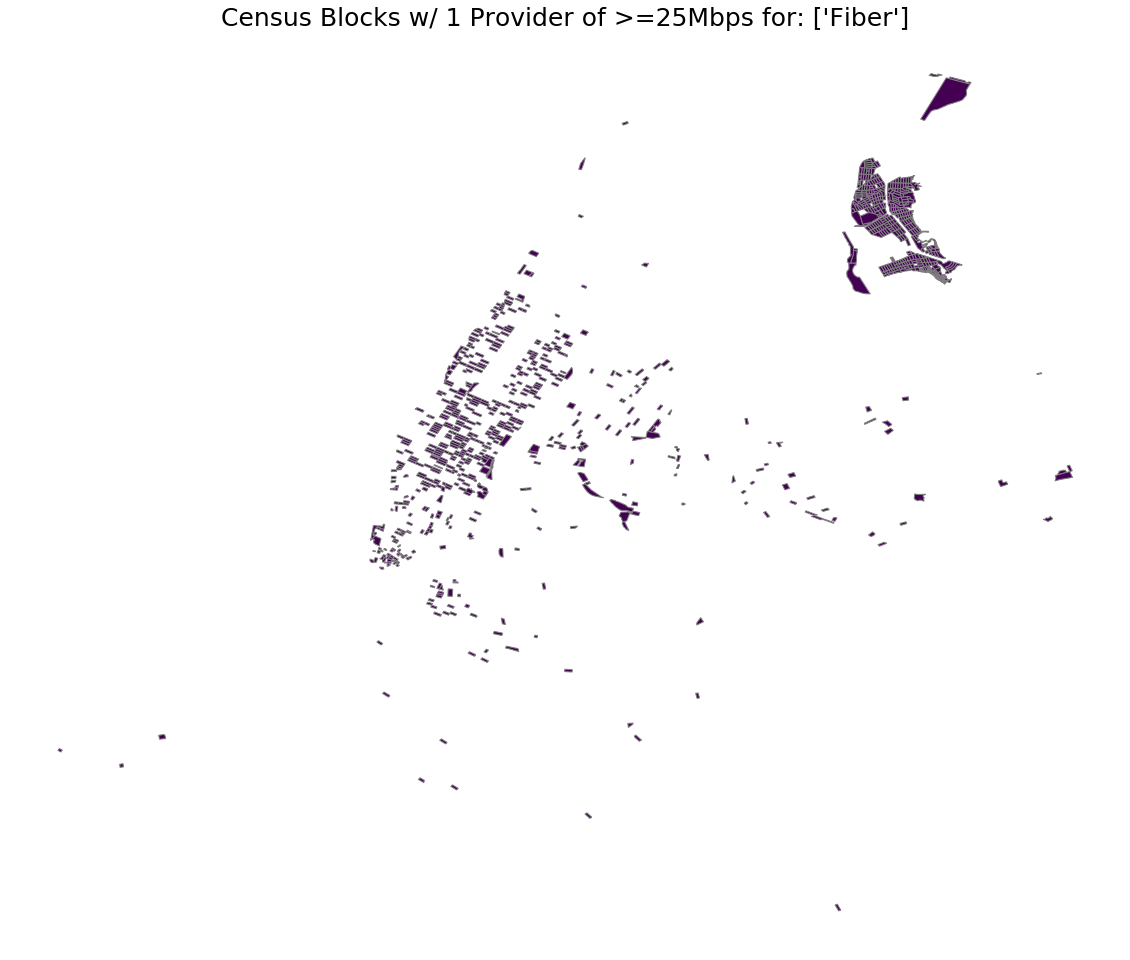

In [212]:
fig, ax = plt.subplots(1, figsize=(20, 20))
ax.axis('off')
ax.set_title('Census Blocks w/ 1 Provider of >=25Mbps for: '+str(tech_code_filter), fontdict={'fontsize': 25, 'fontweight' : '3'})
nyc_gpd[nyc_gpd['unique_providers']==2].plot(column='unique_providers', ax=ax, edgecolor="gray")

In [213]:
print(len(blocksByProviders[blocksByProviders['unique_providers']==1]))
print(blocksByProviders[blocksByProviders['unique_providers']==1].groupby('boro').count())
# blocksByProviders[blocksByProviders['unique_providers']==1]

28955
               FIPS Code  unique_providers
boro                                      
bronx               3620              3620
brooklyn            6830              6830
manhattan           2045              2045
queens             12057             12057
staten island       4403              4403


In [214]:
len(nyc_gpd[nyc_gpd['unique_providers']>=1])

30004